In [1]:
!pip install biopython
!pip install obonet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.9 MB/s eta 0:00:0000:0100:01


In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import Bio
from Bio import SeqIO
import obonet
import gc
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random



In [7]:
obo_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo'
fasta_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta'
term_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv'
taxonomy_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv'

In [8]:
 term_df = pd.read_csv(term_path, sep='\t')

In [9]:
 taxonomy_df = pd.read_csv(taxonomy_path, sep='\t', names=['EntryID', 'taxonomyID'])

In [10]:
taxonomy_df.head()

,EntryID,taxonomyID
0,A0A0C5B5G6,9606
1,A0JNW5,9606
2,A0JP26,9606
3,A0PK11,9606
4,A1A4S6,9606


In [11]:
fasta_data = list(SeqIO.parse(fasta_path, "fasta"))

In [12]:
def get_processed_fasta_df(fasta_data):
    fasta_dict_list = []
    for fasta_seq in fasta_data:
        entry = fasta_seq.id.split('|')[1]
        fasta_dict_list.append({
            "EntryID": entry, 
            "fasta_sequence": str(fasta_seq.seq)
        })
    return pd.DataFrame(fasta_dict_list)

fasta_df = get_processed_fasta_df(fasta_data)
merged_df = pd.merge(term_df, fasta_df, on="EntryID", how='left')
merged_df = pd.merge(merged_df, taxonomy_df, on="EntryID", how="left")

merged_df.head()


,EntryID,term,aspect,fasta_sequence,taxonomyID
0,Q5W0B1,GO:0000785,C,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606
1,Q5W0B1,GO:0004842,F,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606
2,Q5W0B1,GO:0051865,P,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606
3,Q5W0B1,GO:0006275,P,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606
4,Q5W0B1,GO:0006513,P,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606


# EDA

## Counting subontologies 

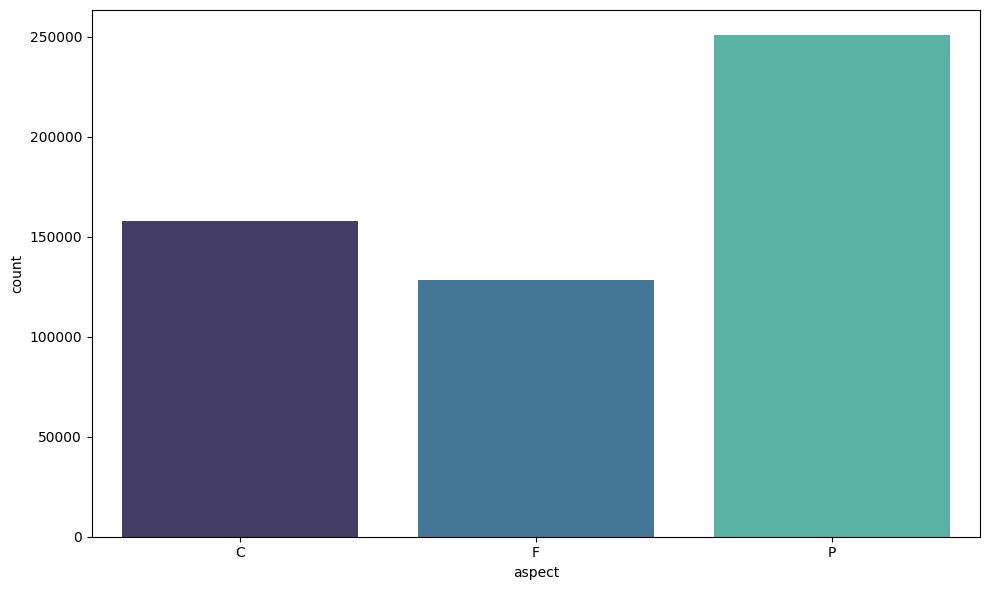

In [13]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(data=term_df, x='aspect', palette='mako')
plt.tight_layout()
plt.show()

## Counting terms for Cellular Component

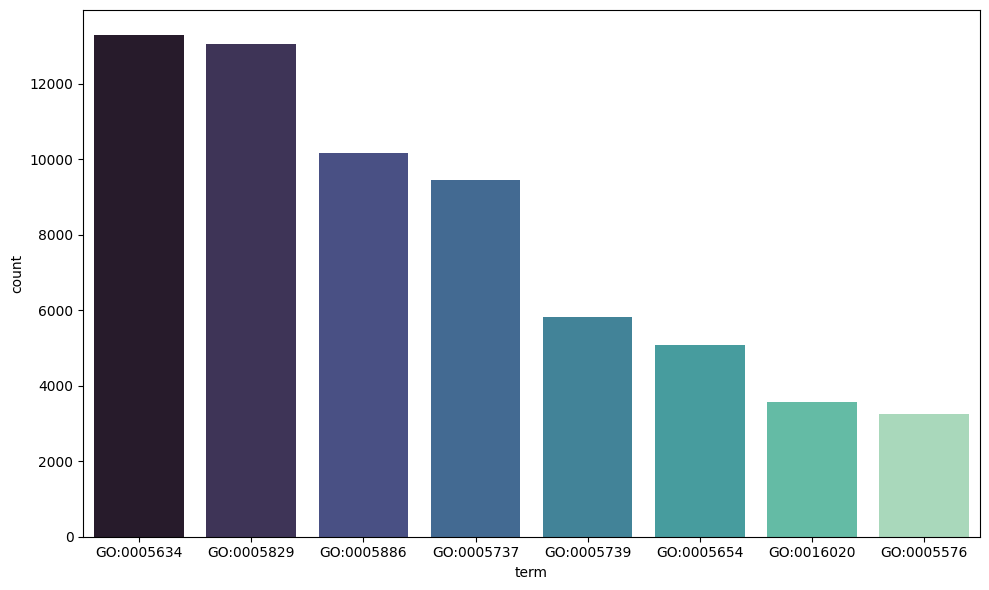

In [14]:
k = 8
k_most_common_c_term_counts = term_df[term_df['aspect'] == 'C']['term'].value_counts().head(k)
k_most_common_c_term = [term for term in k_most_common_c_term_counts.index]
plt.figure(figsize=(10, 6))
sns.countplot(data=term_df[term_df['term'].isin(k_most_common_c_term)], x='term', palette='mako', order=k_most_common_c_term_counts.index)
plt.tight_layout()
plt.show()

## Counting terms for Molecular Function

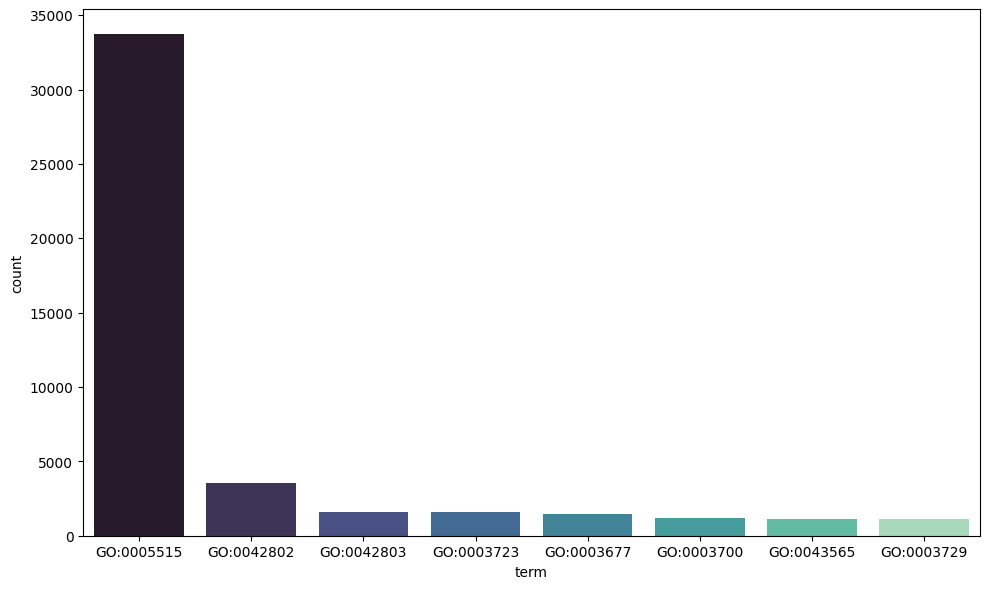

In [15]:
k_most_common_f_term_counts = term_df[term_df['aspect'] == 'F']['term'].value_counts().head(k)
k_most_common_f_term = [term for term in k_most_common_f_term_counts.index]
plt.figure(figsize=(10, 6))
sns.countplot(data=term_df[term_df['term'].isin(k_most_common_f_term)], x='term', palette='mako', order=k_most_common_f_term_counts.index)
plt.tight_layout()
plt.show()

## Counting terms for Biological Process

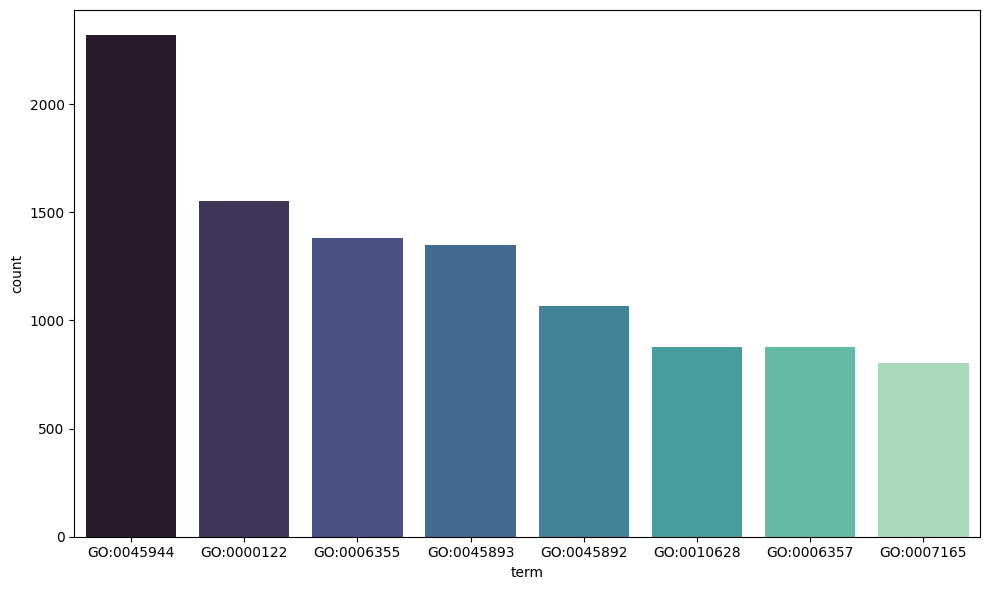

In [16]:
k_most_common_p_term_counts = term_df[term_df['aspect'] == 'P']['term'].value_counts().nlargest(k)
k_most_common_p_term = k_most_common_p_term_counts.index.tolist()
plt.figure(figsize=(10, 6))
sns.countplot(data=term_df[term_df['term'].isin(k_most_common_p_term)], x='term', palette='mako', order=k_most_common_p_term_counts.index)
plt.tight_layout()
plt.show()

## Fasta sequence length histogram with kde, 

/tmp/ipykernel_48/2537220084.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(lengths, bins=500, kde=True, palette="mako")
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


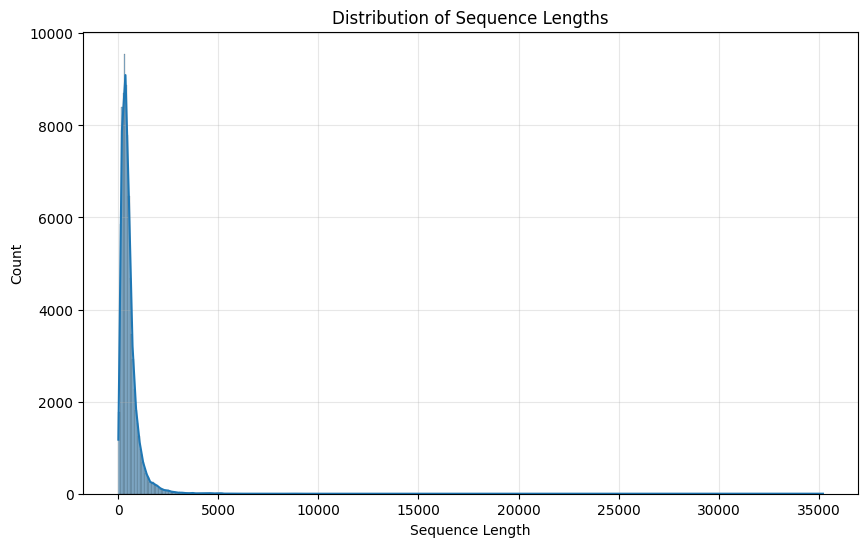

In [17]:
len(fasta_data)
fasta_sequences_list = [str(x.seq) for x in fasta_data]
lengths = [len(seq) for seq in fasta_sequences_list]

plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=500, kde=True, palette="mako")

plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()


## Taxonomies countplot

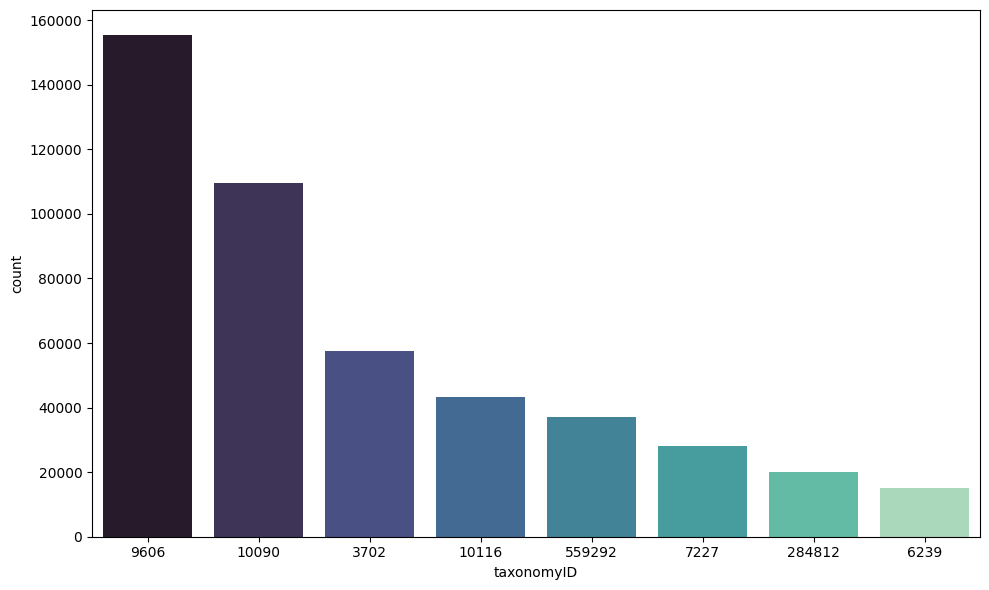

In [18]:
k_most_common_taxonomy_tid_counts = merged_df['taxonomyID'].value_counts().nlargest(k)
k_most_common_taxonomy_id = k_most_common_taxonomy_tid_counts.index.tolist()

subset_df = merged_df[merged_df['taxonomyID'].isin(k_most_common_taxonomy_id)]

plt.figure(figsize=(10, 6))
sns.countplot(
    data=subset_df,
    x='taxonomyID',
    order=k_most_common_taxonomy_tid_counts.index,  # ensures bars are sorted by count
    palette='mako'
)
plt.tight_layout()
plt.show()

## Amino acid counts

In [19]:
from collections import Counter

all_sequences = "".join(merged_df['fasta_sequence'])
aa_counts = Counter(all_sequences)
aa_df = pd.DataFrame.from_dict(aa_counts, orient='index', columns=['count']).sort_values('count', ascending=False)


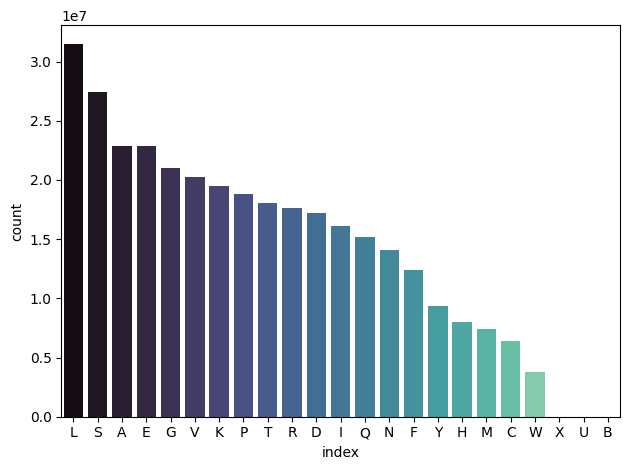

In [20]:
sns.barplot(
    data=aa_df.reset_index(),
    x='index',
    y='count',
    palette='mako'
)
plt.tight_layout()
plt.show()

## Number of GO Terms vs Sequence Length

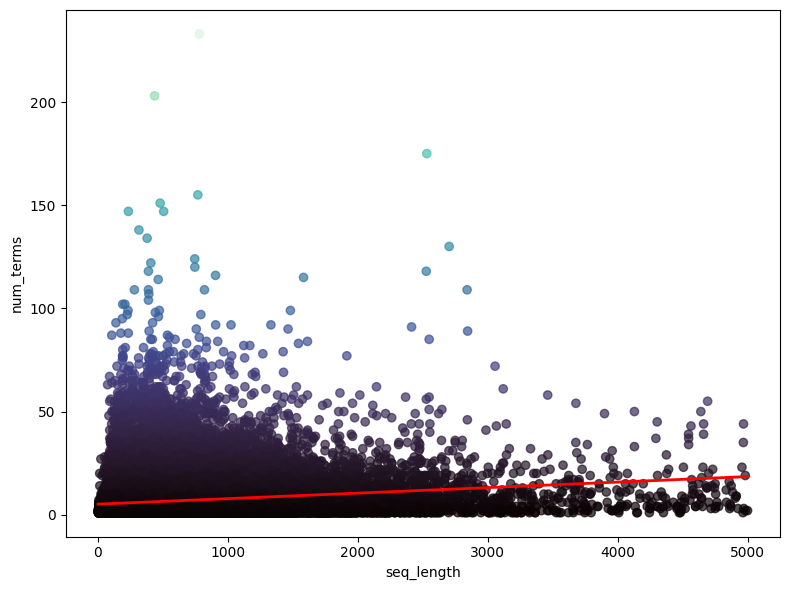

In [21]:
term_counts = merged_df.groupby('EntryID')['term'].nunique().reset_index(name='num_terms')

seq_lengths = merged_df[['EntryID', 'fasta_sequence']].drop_duplicates()
seq_lengths['seq_length'] = seq_lengths['fasta_sequence'].str.len()

entry_stats = pd.merge(term_counts, seq_lengths[['EntryID', 'seq_length']], on='EntryID')

filtered_stats = entry_stats[entry_stats['seq_length'] <= 5000]

plt.figure(figsize=(8,6))
sc = plt.scatter(
    filtered_stats['seq_length'], 
    filtered_stats['num_terms'],
    c=filtered_stats['num_terms'],
    cmap='mako',
    alpha=0.7
)
# Couldn't add palette
sns.regplot(
    x='seq_length',
    y='num_terms',
    data=filtered_stats,
    scatter=False,
    line_kws={'color':'red', 'linewidth':2}
)
plt.tight_layout()
plt.show()